## 1. Time Series Classification Part 1: Feature Creation/Extraction

### (a) Obtain Data

Import packages

In [1]:
import pandas as pd
import numpy as np
import glob

from scipy.stats import bootstrap
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay, roc_auc_score
import statsmodels.api as sm
from sklearn.utils import resample

from sklearn.model_selection import GridSearchCV
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.naive_bayes import GaussianNB, MultinomialNB

import warnings
from sklearn.exceptions import ConvergenceWarning
# from sklearn.preprocessing import Normalizer, StandardScaler

Get the AReM Data Set

### (b) Splitting Data

In [2]:
activities = ["bending1", "bending2", "cycling", "lying", "sitting", "standing", "walking"]
activityToTestData = {}
activityToTrainData = {}

for i in range(len(activities)):
    folderPath = f'../data/AReM/{activities[i]}'
    files = glob.glob(folderPath + "/*.csv")
    files.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))   # sort filename 11 after 2
    
    if i == 0 or i == 1:   # datasets 1 and 2 in bending1 and bending 2 as test data
        test_files = files[:2]
        train_files = files[2:]
    else:                  # datasets 1, 2, and 3 in other folders as test data
        test_files = files[:3]
        train_files = files[3:]

    activityToTestData[activities[i]] = test_files
    activityToTrainData[activities[i]] = train_files

print(activityToTestData)
print(activityToTrainData)

{'bending1': ['../data/AReM/bending1/dataset1.csv', '../data/AReM/bending1/dataset2.csv'], 'bending2': ['../data/AReM/bending2/dataset1.csv', '../data/AReM/bending2/dataset2.csv'], 'cycling': ['../data/AReM/cycling/dataset1.csv', '../data/AReM/cycling/dataset2.csv', '../data/AReM/cycling/dataset3.csv'], 'lying': ['../data/AReM/lying/dataset1.csv', '../data/AReM/lying/dataset2.csv', '../data/AReM/lying/dataset3.csv'], 'sitting': ['../data/AReM/sitting/dataset1.csv', '../data/AReM/sitting/dataset2.csv', '../data/AReM/sitting/dataset3.csv'], 'standing': ['../data/AReM/standing/dataset1.csv', '../data/AReM/standing/dataset2.csv', '../data/AReM/standing/dataset3.csv'], 'walking': ['../data/AReM/walking/dataset1.csv', '../data/AReM/walking/dataset2.csv', '../data/AReM/walking/dataset3.csv']}
{'bending1': ['../data/AReM/bending1/dataset3.csv', '../data/AReM/bending1/dataset4.csv', '../data/AReM/bending1/dataset5.csv', '../data/AReM/bending1/dataset6.csv', '../data/AReM/bending1/dataset7.csv']

### (c) Feature Extraction

In [3]:
time_series = ["avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]

#initialize the final table directionary
summary = {} 
summary["Instance"] = list(range(1,89))
features = ["min", "max", "mean", "median", "std_deviation", "1st_quart", "3rd_quart"]
series_num = list(range(1,7))

for num in series_num:
    for feature in features:
        summary[f"{feature}_{num}"] = []
# print(summary)

for activity in activities:
    folderPath = f'../data/AReM/{activity}'
    files = glob.glob(folderPath + "/*.csv")
    files.sort(key=lambda f: int(''.join(filter(str.isdigit, f)))) 
    
    for instance in tqdm(files):
        df = pd.read_csv(instance, skiprows=range(4)) 

        for i, series in enumerate(time_series):
            cur_series = df[series]
            summary[f"min_{i+1}"].append(cur_series.min())
            summary[f"max_{i+1}"].append(cur_series.max())
            summary[f"mean_{i+1}"].append(cur_series.mean())
            summary[f"median_{i+1}"].append(cur_series.median())
            summary[f"std_deviation_{i+1}"].append(cur_series.std())
            summary[f"1st_quart_{i+1}"].append(cur_series.quantile(q=0.25))
            summary[f"3rd_quart_{i+1}"].append(cur_series.quantile(q=0.75))

features_table = pd.DataFrame(summary)
print(features_table)


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:00<00:00, 361.80it/s]

    Instance  min_1  max_1     mean_1  median_1  std_deviation_1  1st_quart_1  \
0          1  37.25  45.00  40.624792     40.50         1.476967        39.25   
1          2  38.00  45.67  42.812812     42.50         1.435550        42.00   
2          3  35.00  47.40  43.954500     44.33         1.558835        43.00   
3          4  33.00  47.75  42.179812     43.50         3.670666        39.15   
4          5  33.00  45.75  41.678063     41.75         2.243490        41.33   
..       ...    ...    ...        ...       ...              ...          ...   
83        84  19.50  45.33  33.586875     34.25         4.650935        30.25   
84        85  19.75  45.50  34.322750     35.25         4.752477        31.00   
85        86  19.50  46.00  34.546229     35.25         4.842294        31.25   
86        87  23.50  46.25  34.873229     35.25         4.531720        31.75   
87        88  19.25  44.00  34.473188     35.00         4.796705        31.25   

    3rd_quart_1  min_2  max

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression

#### i. Plots

In 1c(iv) I chose mean, median and 3rd quartile.

100%|██████████| 12/12 [00:00<00:00, 520.54it/s]


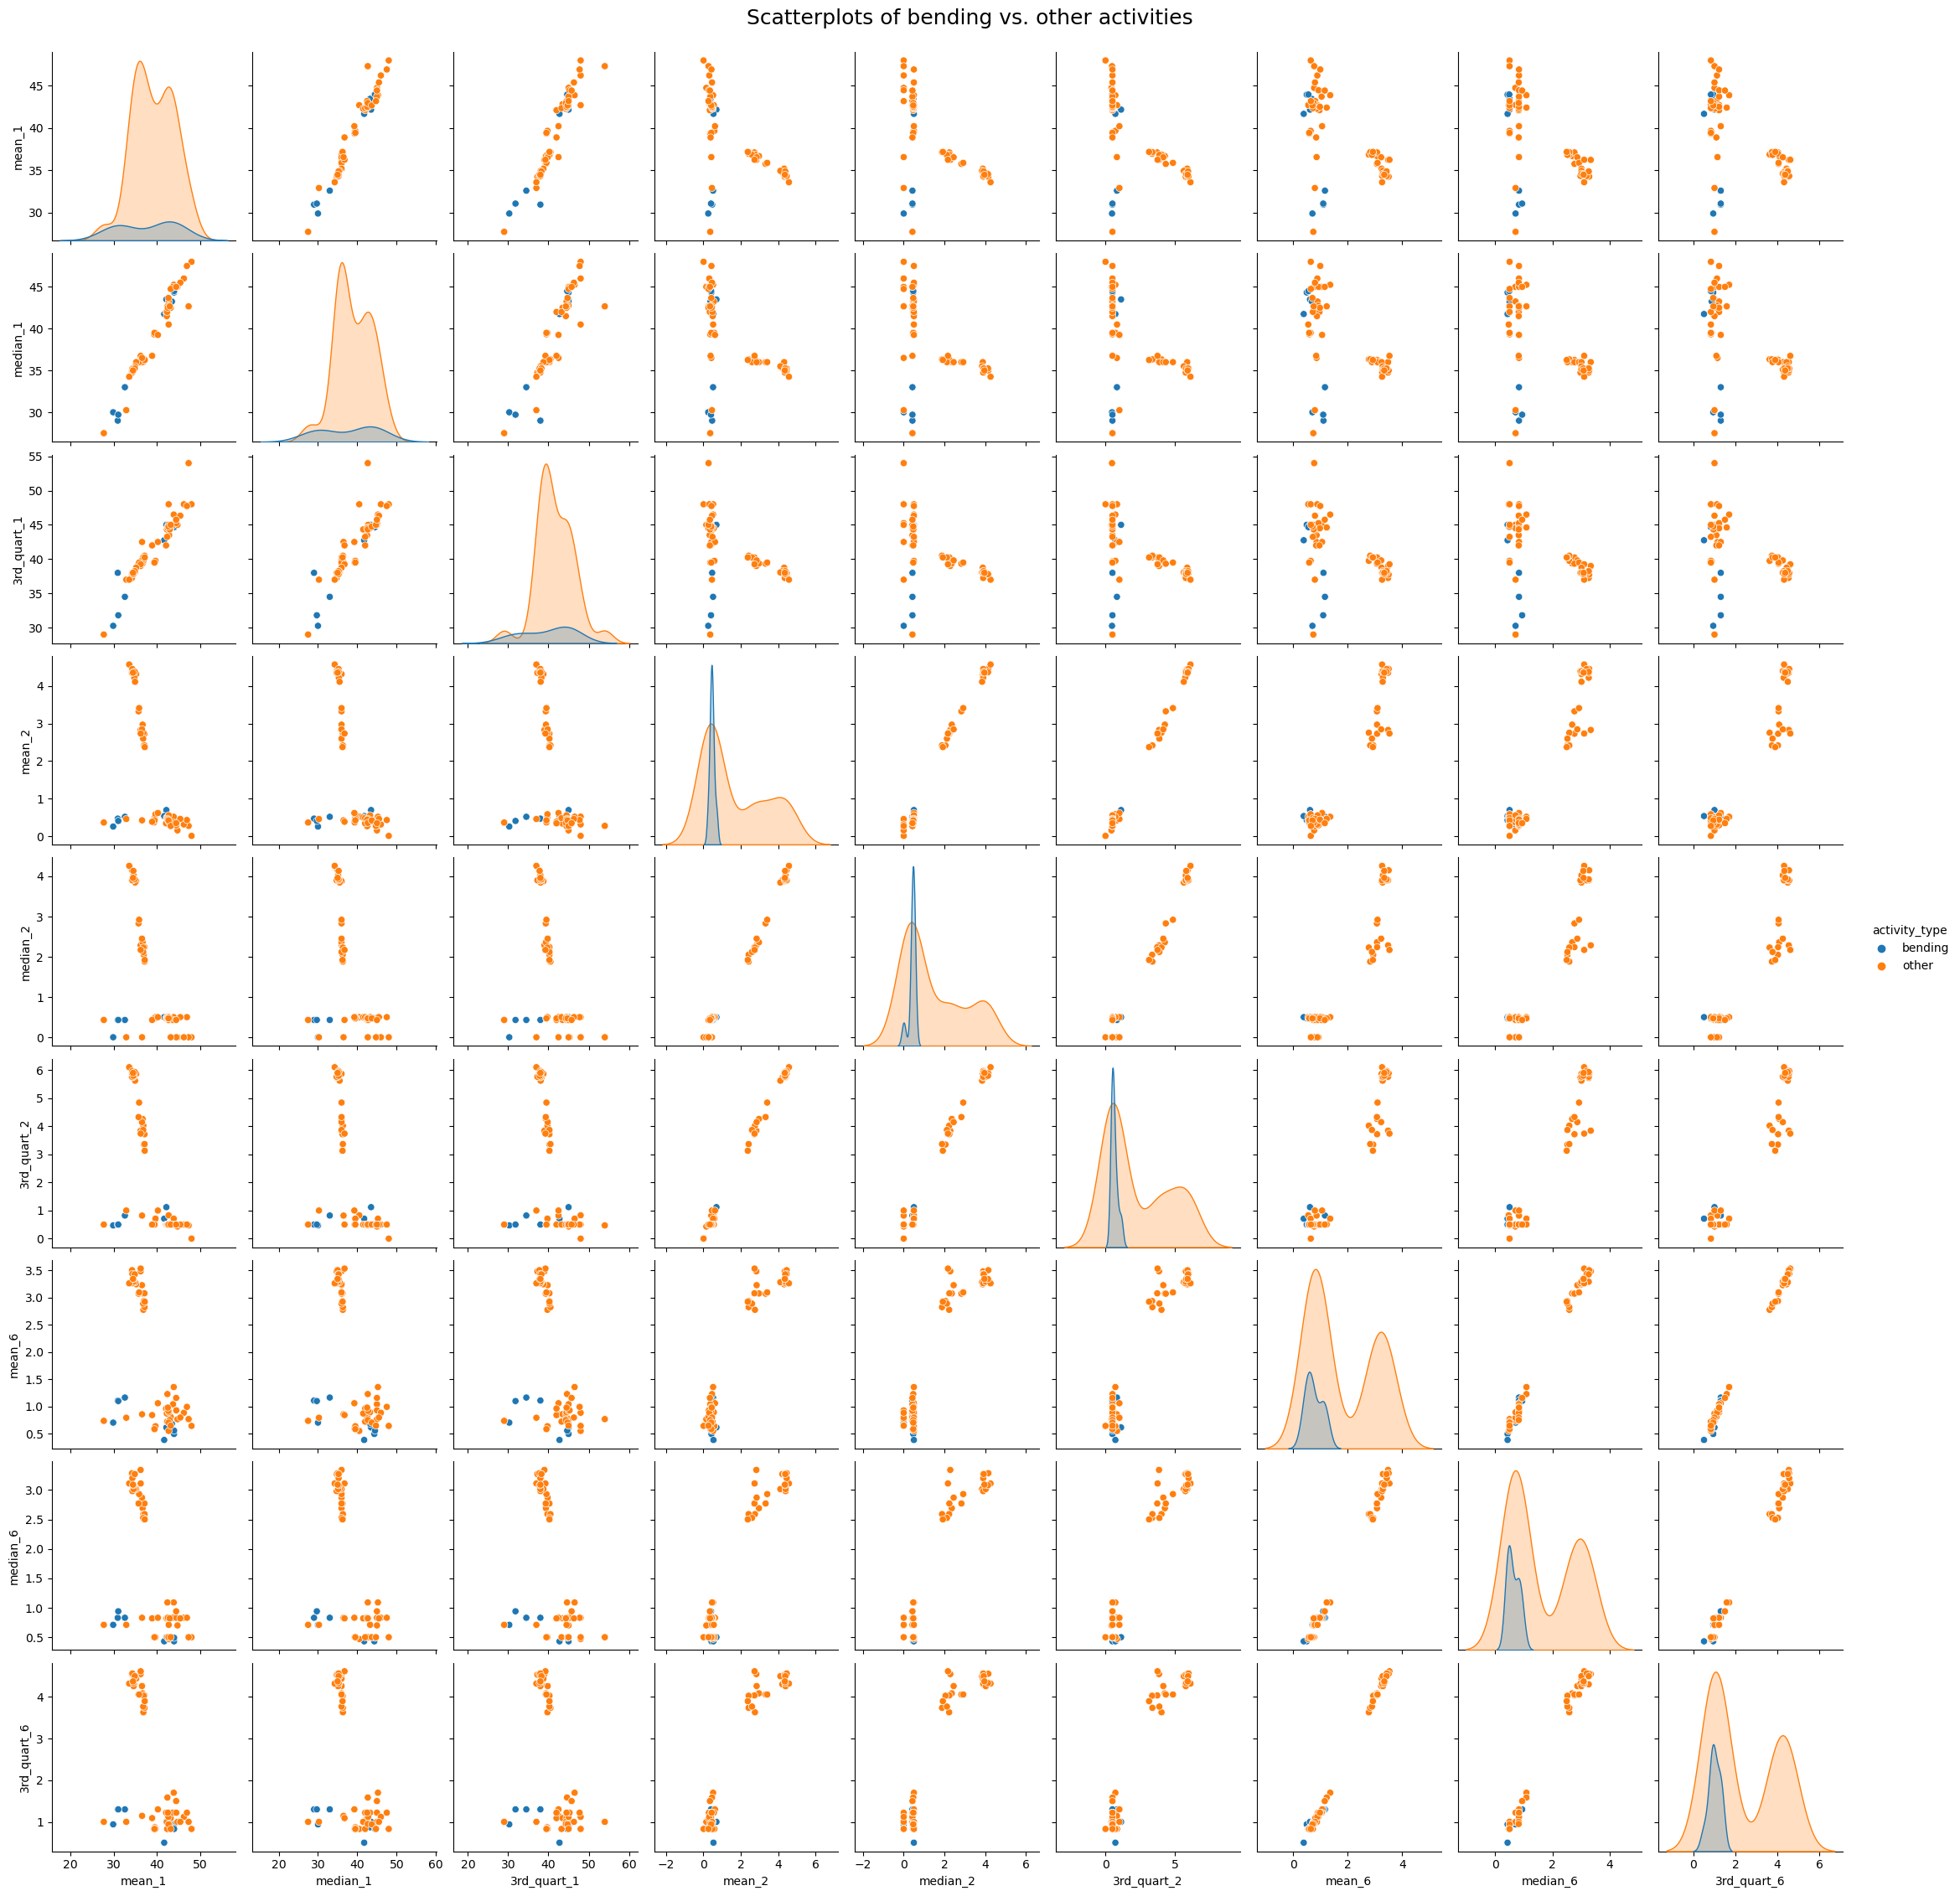

In [14]:
selected_series = ["avg_rss12", "var_rss12", "var_rss23"]
selected_series_num = [1, 2, 6]
selected_features = ["mean", "median", "3rd_quart"]

summary = {} 
summary["activity_type"] = []
for num in selected_series_num:
    for feature in selected_features:
        summary[f"{feature}_{num}"] = []

for activity in activities:
    files = activityToTrainData[activity]
    for instance in tqdm(files):
        if activity == "bending1" or activity == "bending2":
                summary["activity_type"].append("bending")
        else:
            summary["activity_type"].append("other")

        df = pd.read_csv(instance, skiprows=range(4)) 
        for i, series in enumerate(selected_series):
            num = selected_series_num[i]
            cur_series = df[series]
            
            summary[f"mean_{num}"].append(cur_series.mean())
            summary[f"median_{num}"].append(cur_series.median())
            summary[f"3rd_quart_{num}"].append(cur_series.quantile(q=0.75))
            

bendingVsOther = pd.DataFrame(summary)
scatter = sns.pairplot(bendingVsOther, hue="activity_type")
scatter.fig.suptitle("Scatterplots of bending vs. other activities", y = 1.01,size = 18)
plt.show()

#### ii. Splitted Plots

100%|██████████| 12/12 [00:00<00:00, 307.76it/s]


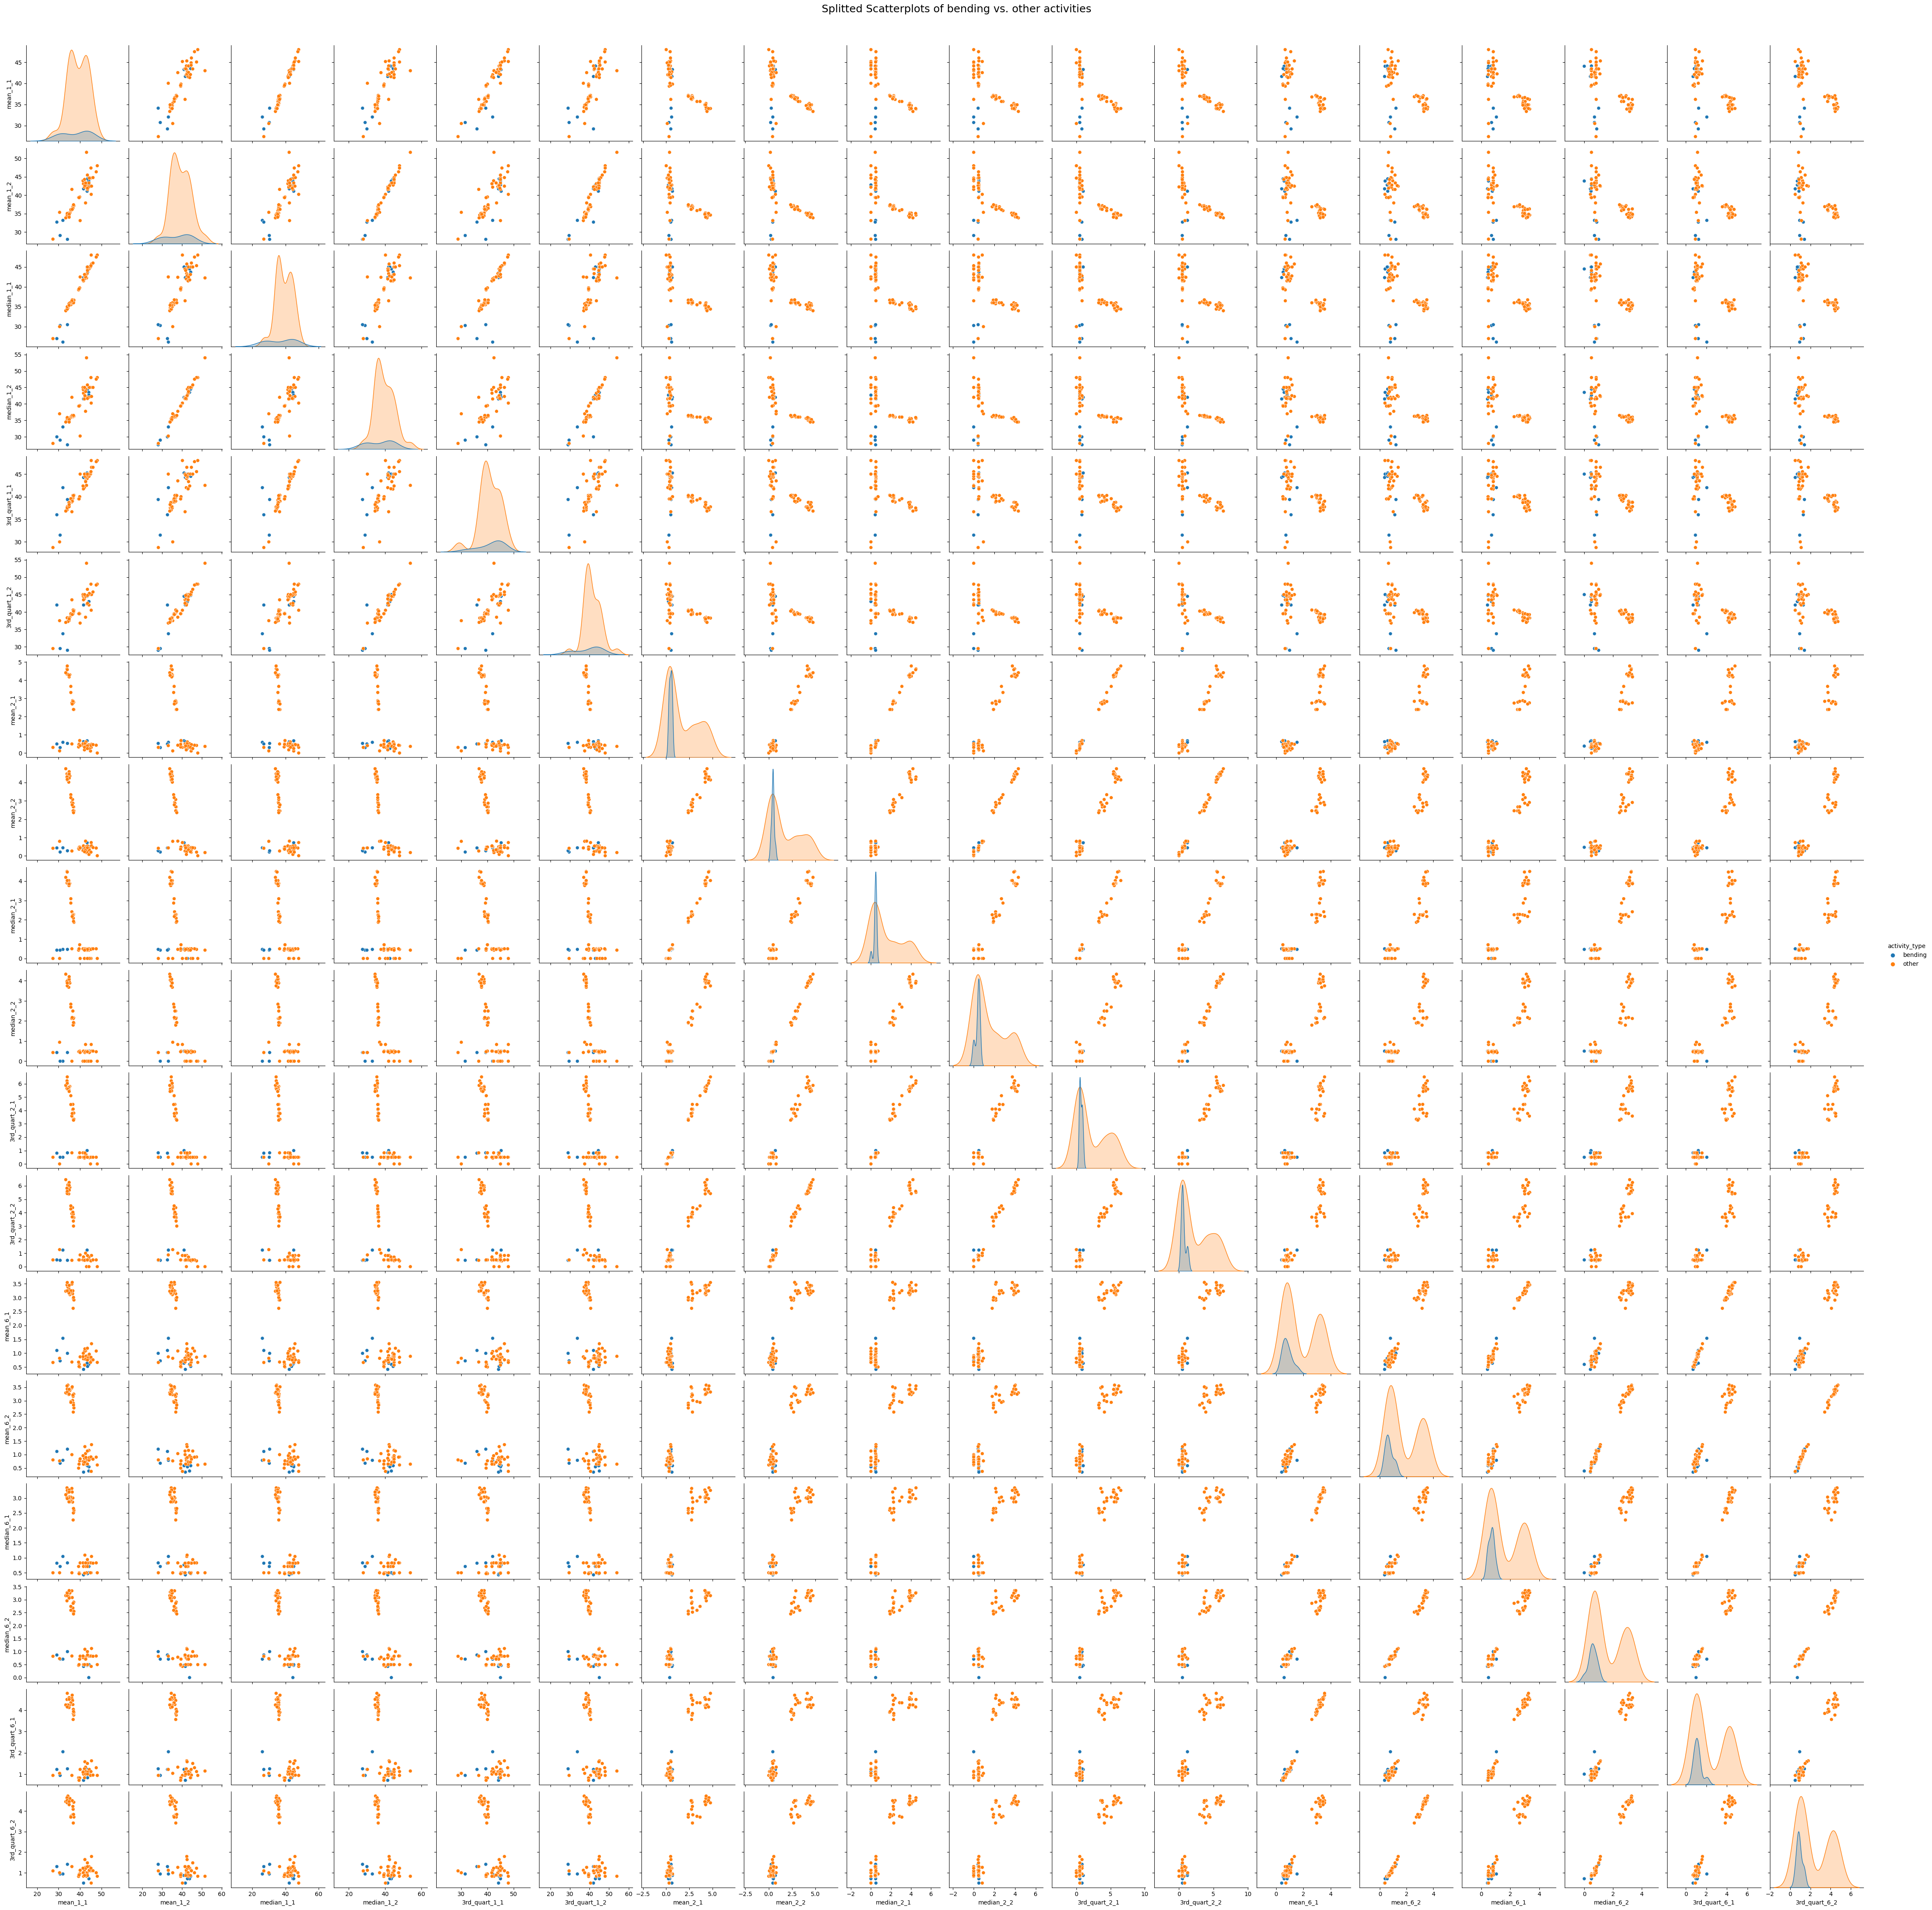

In [15]:
summary = {} 
summary["activity_type"] = []
for num in selected_series_num:
    for feature in selected_features:
        for i in range(1,3):
            summary[f"{feature}_{num}_{i}"] = []

for activity in activities:
    files = activityToTrainData[activity]
    for instance in tqdm(files):
        if activity == "bending1" or activity == "bending2":
                summary["activity_type"].append("bending")
        else:
            summary["activity_type"].append("other")

        df = pd.read_csv(instance, skiprows=range(4)) 
        for i, series in enumerate(selected_series):
            num = selected_series_num[i]
            cur_series = df[series]
            mid = len(cur_series) // 2
            
            summary[f"mean_{num}_1"].append(cur_series[:mid].mean())
            summary[f"median_{num}_1"].append(cur_series[:mid].median())
            summary[f"3rd_quart_{num}_1"].append(cur_series[:mid].quantile(q=0.75))
            summary[f"mean_{num}_2"].append(cur_series[mid:].mean())
            summary[f"median_{num}_2"].append(cur_series[mid:].median())
            summary[f"3rd_quart_{num}_2"].append(cur_series[mid:].quantile(q=0.75))
     
bendingVsOther2 = pd.DataFrame(summary)
scatter2 = sns.pairplot(bendingVsOther2, hue="activity_type")
scatter2.fig.suptitle("Splitted Scatterplots of bending vs. other activities", y = 1.01,size = 18)
plt.show()

I didn't see any considerable difference between the results in i and ii.

#### iii. Time Series Segments

In [17]:
activities = ["bending1", "bending2", "cycling", "lying", "sitting", "standing", "walking"]
time_series = ["avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]
selected_features = ["mean", "median", "3rd_quart"]

def split_series(series, split_fold):
    series_length = int(round(len(series) / split_fold, 0))
    i = 0
    series_list = []
    while i < split_fold - 1:
        series_list.append(series[i * series_length: (i+1) * series_length])
        i += 1

    series_list.append(series[i * series_length:])
    return series_list

def build_dataset(data_dict, split_fold):
    """
    Takes the data dictionary built in 1 b), 
    and the splitFold l (1 <= l <= 20) which determins the number of features in the dataset.
    Returns a dataframe with all training or test data at given split_fold
    """

    summary = {} 
    summary["activity_type"] = []

    for i in range(len(time_series)):
        for feature in selected_features:
            for j in range(split_fold):
                # example: median_1_3 means the median of the 1st time_domain features' 3rd part
                summary[f"{feature}_{i+1}_{j+1}"] = []   
                
    # for activity in tqdm(activities):
    for activity in activities:
        files = data_dict[activity]
        for instance in files:
            if activity == "bending1" or activity == "bending2":
                summary["activity_type"].append(1)
            else:
                summary["activity_type"].append(0)
            
            df = pd.read_csv(instance, skiprows=range(4)) 

            for i, series in enumerate(time_series):
                cur_series = df[series]
                series_list = split_series(cur_series, split_fold)
                
                for j in range(split_fold):
                    summary[f"mean_{i+1}_{j+1}"].append(series_list[j].mean())
                    summary[f"median_{i+1}_{j+1}"].append(series_list[j].median())
                    summary[f"3rd_quart_{i+1}_{j+1}"].append(series_list[j].quantile(q=0.75))
        
    return pd.DataFrame(summary)

def get_pruned_features(selector):
    names = selector.feature_names_in_
    mask = selector.support_

    pruned = []
    for i in range(len(names)):
        if mask[i] == True:
            pruned.append(names[i])

    return pruned



In [5]:
for l in range(1,21):
    train_set = build_dataset(activityToTrainData, l)
    X_train = train_set[train_set.columns[1:]]
    y_train = train_set[train_set.columns[0]]
    print("l = ", l)
    print("X shape", X_train.shape)
    print("----")


l =  1
X shape (69, 18)
----
l =  2
X shape (69, 36)
----
l =  3
X shape (69, 54)
----
l =  4
X shape (69, 72)
----
l =  5
X shape (69, 90)
----
l =  6
X shape (69, 108)
----
l =  7
X shape (69, 126)
----
l =  8
X shape (69, 144)
----
l =  9
X shape (69, 162)
----
l =  10
X shape (69, 180)
----
l =  11
X shape (69, 198)
----
l =  12
X shape (69, 216)
----
l =  13
X shape (69, 234)
----
l =  14
X shape (69, 252)
----
l =  15
X shape (69, 270)
----
l =  16
X shape (69, 288)
----
l =  17
X shape (69, 306)
----
l =  18
X shape (69, 324)
----
l =  19
X shape (69, 342)
----
l =  20
X shape (69, 360)
----


In [17]:
res = {}
res["l"] = []
res["p"] = []
res["cv_accuracy"] = []
max_score = 0
pruned_features = []

for l in range(1,21):
    train_set = build_dataset(activityToTrainData, l)
    X_train = train_set[train_set.columns[1:]]
    y_train = train_set[train_set.columns[0]]

    model = LogisticRegression(penalty=None, max_iter=500)
    selector = RFECV(model, cv=StratifiedKFold(5, shuffle=True, random_state=23), scoring='accuracy')  
    selector.fit(X_train, y_train)
    p = selector.n_features_
    score = max(selector.cv_results_['mean_test_score'])

    if score > max_score:
        pruned_features = get_pruned_features(selector)
        max_score = score

    res["l"].append(l)
    res["p"].append(p)
    res["cv_accuracy"].append(score)

result = pd.DataFrame(res)
print(result)
print(result.loc[result["cv_accuracy"].idxmax()])
# print(pruned_features)

100%|██████████| 7/7 [00:02<00:00,  2.68it/s]


     l   p  cv_accuracy
0    1   5     0.971429
1    2   6     0.927473
2    3   7     0.971429
3    4  11     0.971429
4    5   6     1.000000
5    6   3     0.970330
6    7  43     0.957143
7    8   5     0.971429
8    9  50     0.971429
9   10   1     0.957143
10  11  10     0.970330
11  12   4     0.970330
12  13   4     0.970330
13  14   3     0.970330
14  15  42     0.971429
15  16   1     1.000000
16  17   1     0.971429
17  18  53     0.957143
18  19   2     0.970330
19  20   5     0.970330
l              5.0
p              6.0
cv_accuracy    1.0
Name: 4, dtype: float64


(l, p) pair (5, 6) gives the best cross validation score of 1.0.

Wrong way to do cross validation: apply cross validation only after the training process.
  
Right way: apply cross validation to the model with all predictors during the training process, then use cross validation to selesct the most significant predictors.


#### iv. Confusion Matrix

In [30]:
def plot_confusion_matrix(y, y_pred, dataType, label=None):
    cm = confusion_matrix(y, y_pred)
    cm_display = ConfusionMatrixDisplay(cm, display_labels=label).plot()
    cm_display.ax_.set_title(f"Confusion Matrix for {dataType} data")

def plot_ROC(classifier, X, y, dataType):
    # print(classifier.predict_proba(X))
    y_prob = classifier.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)
    print('AUC:', roc_auc)

    RocCurveDisplay.from_predictions(
        y,
        y_prob,
        name="bending vs other",
        color="darkorange",
    )
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC curve on {dataType} data")
    plt.legend()
    plt.show()

100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


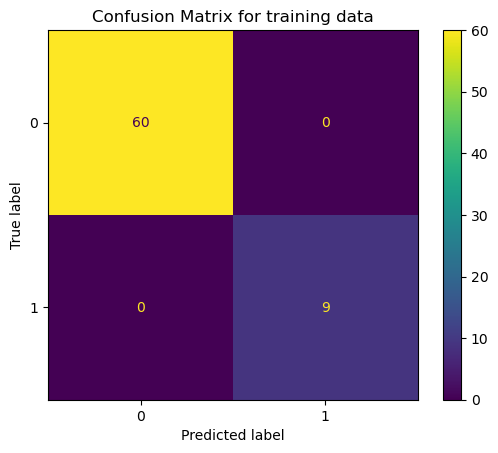

In [19]:
l = 5

train_set = build_dataset(activityToTrainData, l)
X_train = train_set[pruned_features]
y_train = train_set.activity_type
classifier = LogisticRegression(max_iter=500)
classifier.fit(X_train, y_train)

y_train_pred = classifier.predict(X_train)
plot_confusion_matrix(y_train, y_train_pred, "training")

AUC: 1.0


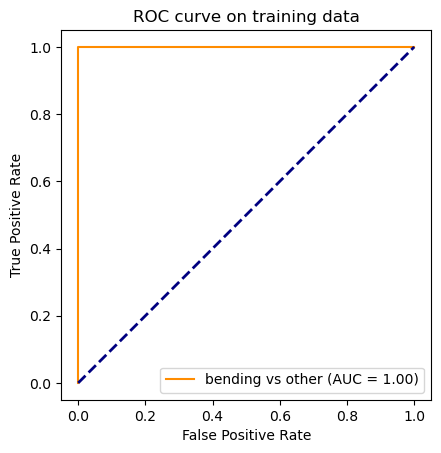

In [20]:
plot_ROC(classifier, X_train, y_train, "training")

In [21]:
X_train_ = sm.add_constant(X_train)
logit_mod = sm.Logit(y_train, X_train_)
logit_res = logit_mod.fit(method='bfgs')

print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 24
         Function evaluations: 27
         Gradient evaluations: 27
                           Logit Regression Results                           
Dep. Variable:          activity_type   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Mon, 16 Oct 2023   Pseudo R-squ.:                   1.000
Time:                        20:33:04   Log-Likelihood:            -1.2051e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 9.588e-10
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.1688   2.26e

The data are linearly seperatable, and thus the logistic regression needs to be terminated pre-maturely. The p-values here are not reliable.

#### v. Test Classifier

100%|██████████| 7/7 [00:00<00:00, 21.31it/s]


Test score: 1.0
AUC: 1.0


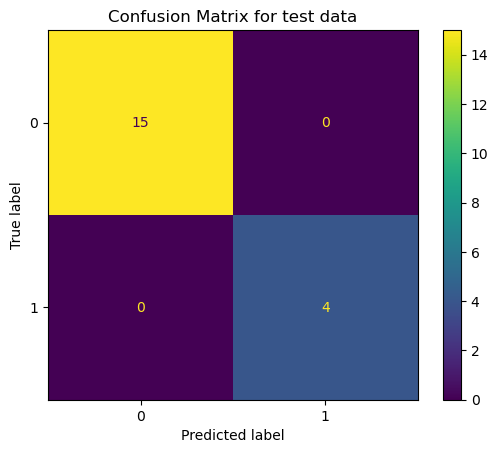

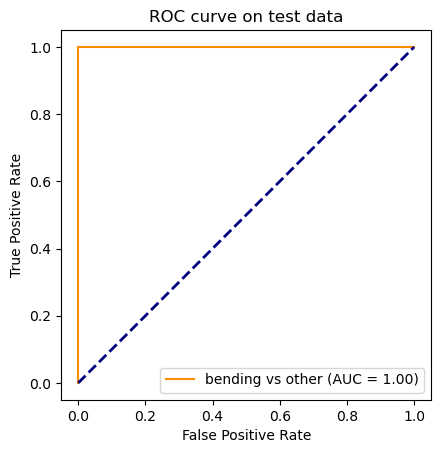

In [22]:
l = 5    
test_set = build_dataset(activityToTestData, l)
X_test = test_set[pruned_features]
y_test = test_set[test_set.columns[0]]

y_test_pred = classifier.predict(X_test)
test_score = classifier.score(X_test, y_test)
print("Test score:", test_score)
plot_confusion_matrix(y_test, y_test_pred, "test")
plot_ROC(classifier, X_test, y_test, "test")

The accuracy on the test set （1.0） is the same as the cross-validation accuracy (1.0) obtained previously.

#### vi. Separation

Yes. 
1. There was warning during skitlearn logistic regression fitting for reaching maximum iteration (default=100), which suggests the data are well separated.
2. The statsmodels fitting results also says there is complete separation or perfect prediction.

#### vii. Imbalance

Yes, there is class imbalance. The number of positive class (bending) only accounts for less than 1/7 of the total cases. However the test accuracy was already 1.0 before case-control sampling.  
Here I tried downsampling and upsampling. 

AUC: 1.0


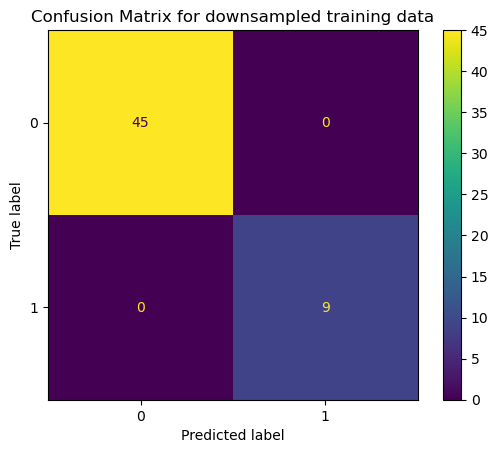

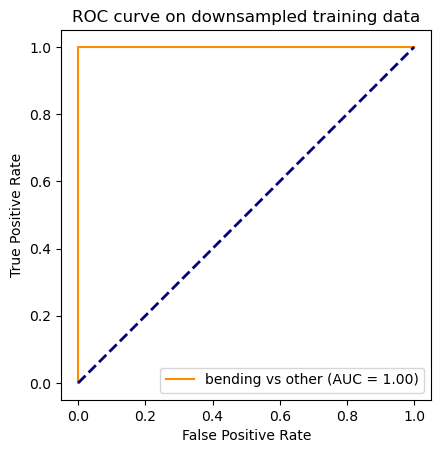

Test score of class-balanced model: 1.0
AUC: 1.0


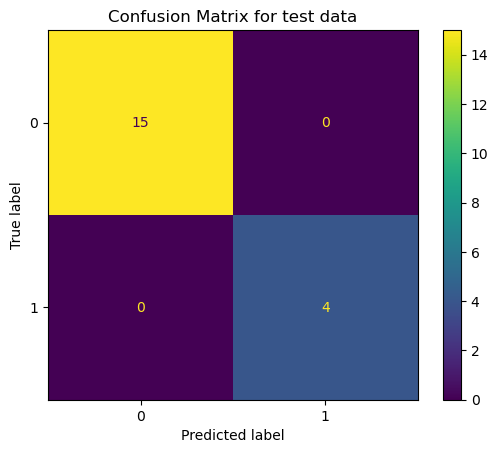

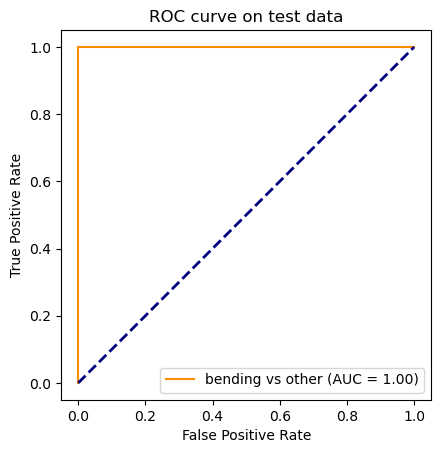

In [23]:
# Downsampling
df = train_set
df_majority = df[df['activity_type']==0]
df_minority = df[df['activity_type']==1]

df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=45,     # 5 times of minority class
                                 random_state=13)
train_set_downsampled = pd.concat([df_majority_downsampled, df_minority])

X_train_d = train_set_downsampled[pruned_features]
y_train_d = train_set_downsampled.activity_type
classifier_d = LogisticRegression(max_iter=500)
classifier_d.fit(X_train_d, y_train_d)

y_train_pred = classifier_d.predict(X_train_d)
plot_confusion_matrix(y_train_d, y_train_pred, "downsampled training")
plot_ROC(classifier_d, X_train_d, y_train_d, "downsampled training")

y_test_pred = classifier_d.predict(X_test)
test_score_d = classifier_d.score(X_test, y_test)
print("Test score of class-balanced model:", test_score_d)
plot_confusion_matrix(y_test, y_test_pred, "test")
plot_ROC(classifier, X_test, y_test, "test")

AUC: 1.0


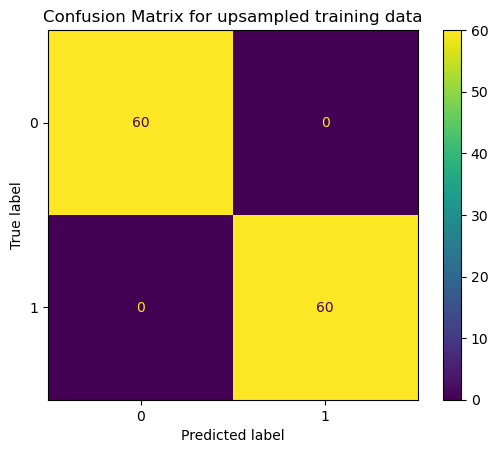

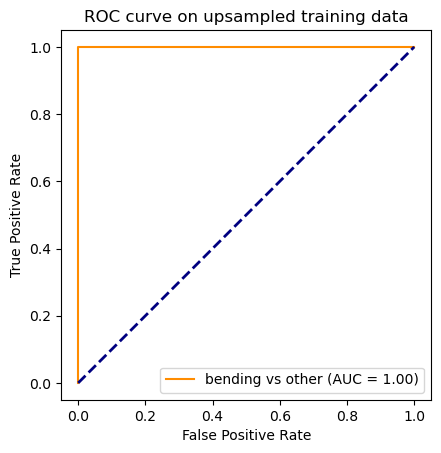

Test score of class-balanced model: 1.0
AUC: 1.0


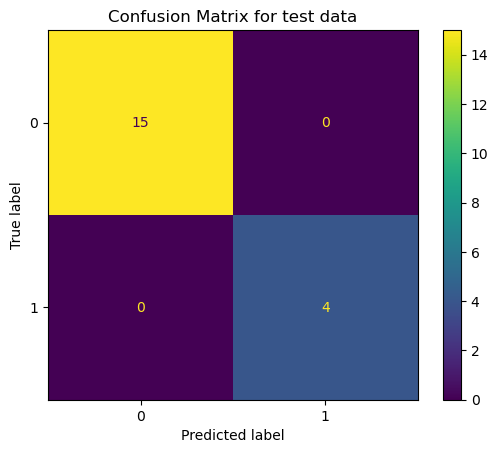

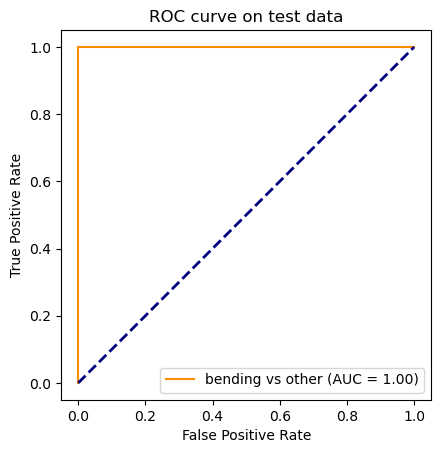

In [24]:
# Upsampling

df = train_set
df_majority = df[df['activity_type']==0]
df_minority = df[df['activity_type']==1]

df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples=60,     # to match majority class
                                 random_state=13)
train_set_upsampled = pd.concat([df_majority, df_minority_upsampled])

X_train_u = train_set_upsampled[pruned_features]
y_train_u = train_set_upsampled.activity_type
classifier_u = LogisticRegression(max_iter=500)
classifier_u.fit(X_train_u, y_train_u)

y_train_pred = classifier_u.predict(X_train_u)
plot_confusion_matrix(y_train_u, y_train_pred, "upsampled training")
plot_ROC(classifier_u, X_train_u, y_train_u, "upsampled training")

y_test_pred = classifier_u.predict(X_test)
test_score_u = classifier_u.score(X_test, y_test)
print("Test score of class-balanced model:", test_score_u)
plot_confusion_matrix(y_test, y_test_pred, "test")
plot_ROC(classifier, X_test, y_test, "test")

### (b) Binary Classification Using L1-penalized logistic regression

#### i. Time Series Segments
Repeat (a)iii using L1-penalized logistic regression

In [25]:
res = {}
res["l"] = []
res["lambda"] = []
res["train_accuracy"] = []
max_score = 0
best_model = None

for l in range(1,21):
    train_set = build_dataset(activityToTrainData, l)
    X_train = train_set[train_set.columns[1:]]
    # X_train = Normalizer(norm='l1').fit_transform(X_train)    doesn't help

    y_train = train_set[train_set.columns[0]]

    model = LogisticRegression(penalty='l1', max_iter=250, solver='liblinear')

    selector = GridSearchCV(model, param_grid=[{'C': np.logspace(-4, 4, 20)}],
                            cv=StratifiedKFold(5, shuffle=True, random_state=23),
                            verbose=True)

    selector.fit(X_train, y_train)
    lam = selector.best_params_['C']
    score = selector.best_score_
    if score > max_score:
        best_model = selector.best_estimator_
        max_score = score


    res["l"].append(l)
    res["lambda"].append(lam)
    res["train_accuracy"].append(score)

result = pd.DataFrame(res)
print(result)
print(result.loc[result["train_accuracy"].idxmax()])
print(best_model)


100%|██████████| 7/7 [00:00<00:00, 24.57it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 7/7 [00:00<00:00, 20.63it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 7/7 [00:00<00:00, 14.89it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 7/7 [00:00<00:00, 11.86it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 7/7 [00:00<00:00,  9.83it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 7/7 [00:00<00:00,  8.35it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 7/7 [00:00<00:00,  7.24it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 7/7 [00:01<00:00,  6.39it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 7/7 [00:01<00:00,  5.55it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 7/7 [00:01<00:00,  5.21it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 7/7 [00:01<00:00,  4.69it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 7/7 [00:01<00:00,  4.35it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 7/7 [00:01<00:00,  4.04it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 7/7 [00:01<00:00,  3.72it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 7/7 [00:01<00:00,  3.54it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 7/7 [00:02<00:00,  3.33it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 7/7 [00:02<00:00,  3.13it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 7/7 [00:02<00:00,  2.97it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits


100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


Fitting 5 folds for each of 20 candidates, totalling 100 fits
     l      lambda  train_accuracy
0    1   29.763514        0.971429
1    2    0.615848        0.957143
2    3    0.233572        0.956044
3    4  545.559478        0.971429
4    5    1.623777        0.956044
5    6  545.559478        0.971429
6    7  545.559478        0.942857
7    8    0.088587        0.970330
8    9  545.559478        0.942857
9   10  545.559478        0.942857
10  11    0.615848        0.970330
11  12  206.913808        0.971429
12  13    0.088587        0.970330
13  14  545.559478        0.957143
14  15   78.475997        0.971429
15  16  206.913808        0.957143
16  17    0.233572        0.956044
17  18  206.913808        0.957143
18  19   78.475997        0.957143
19  20    0.088587        0.970330
l                  1.000000
lambda            29.763514
train_accuracy     0.971429
Name: 0, dtype: float64
LogisticRegression(C=29.763514416313132, max_iter=250, penalty='l1',
                   solver=

Using unnormalized features, several models with different (l, lambda) pairs give the same best train accuracy (0.971429).  
I choose the model of l = 1 and lambda = 29.76.

#### ii. Comparison

100%|██████████| 7/7 [00:00<00:00, 115.07it/s]


Test score: 1.0
AUC: 1.0


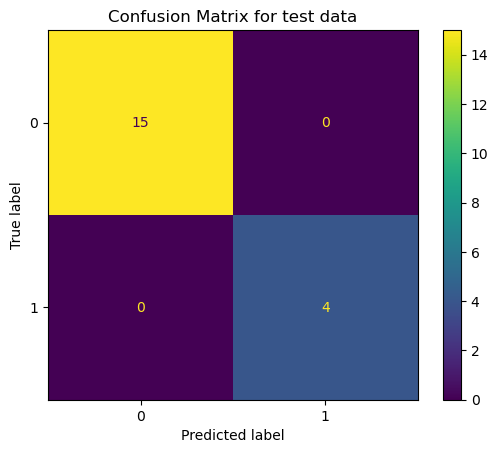

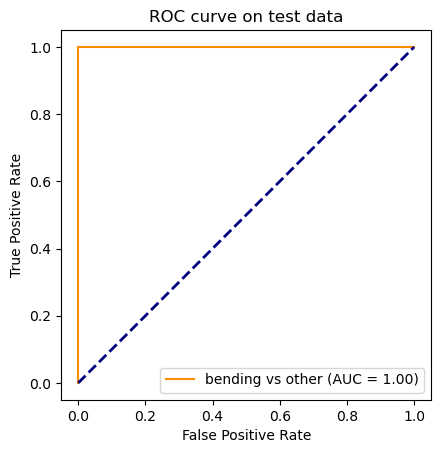

In [26]:
# test the best model with test data
clf = best_model
l = 1

train_set = build_dataset(activityToTrainData, l)
X_train = train_set[train_set.columns[1:]]
y_train = train_set[train_set.columns[0]]
clf.fit(X_train, y_train)

test_set = build_dataset(activityToTestData, l)
X_test = test_set.drop('activity_type',axis=1)
y_test = test_set.activity_type

y_test_pred = clf.predict(X_test)
test_score = clf.score(X_test, y_test)
print("Test score:", test_score)
plot_confusion_matrix(y_test, y_test_pred, "test")
plot_ROC(clf, X_test, y_test, "test")

Both models perform well with a test accuracy of 1.0.
The implementation difficulty are similar using sklearn packages. But building L1-penalized model takes significantly shorter time than doing feature selection using RFECV.

### (c) Multi-class Classification (The Realistic Case)

#### i. Time Series Segments

In [22]:
# def build_ohe_dataset(data_dict, split_fold):
#     """
#     Takes the data dictionary built in 1 b), 
#     and the splitFold l (1 <= l <= 20) which determins the number of features in the dataset.
#     Code all activiteis with one hot encoding.
#     Returns a dataframe with all training or test data at given split_fold
#     """

#     summary = {} 
#     summary["activity_type"] = []

#     for i in range(len(time_series)):
#         for feature in selected_features:
#             for j in range(split_fold):
#                 # example: median_1_3 means the median of the 1st time_domain features' 3rd part
#                 summary[f"{feature}_{i+1}_{j+1}"] = []   
                
#     # for activity in activities:
#     for activity in tqdm(activities):
#         files = data_dict[activity]
#         for instance in files:
#             if activity == "bending1" or activity == "bending2":
#                 summary["activity_type"].append("bending")
#             else:
#                 summary["activity_type"].append(activity)
            
#             df = pd.read_csv(instance, skiprows=range(4)) 

#             for i, series in enumerate(time_series):
#                 cur_series = df[series]
#                 series_list = split_series(cur_series, split_fold)
                
#                 for j in range(split_fold):
#                     summary[f"mean_{i+1}_{j+1}"].append(series_list[j].mean())
#                     summary[f"median_{i+1}_{j+1}"].append(series_list[j].median())
#                     summary[f"3rd_quart_{i+1}_{j+1}"].append(series_list[j].quantile(q=0.75))
    
#     df = pd.DataFrame(summary)

#     ohe = OneHotEncoder()
#     class_array = ohe.fit_transform(df[["activity_type"]]).toarray()
#     class_labels = np.array(ohe.categories_).ravel()
#     class_df = pd.DataFrame(class_array, columns = class_labels)
#     df_ohe = pd.concat([df, class_df], axis=1)

#     return df_ohe.drop(['activity_type'], axis=1)

def build_multi_dataset(data_dict, split_fold):
    """
    Takes the data dictionary built in 1 b), 
    and the splitFold l (1 <= l <= 20) which determins the number of features in the dataset.
    Code all activiteis ordinally.
    Returns a dataframe with all training or test data at given split_fold
    """

    summary = {} 
    summary["activity_type"] = []

    for i in range(len(time_series)):
        for feature in features:
            for j in range(split_fold):
                # example: median_1_3 means the median of the 1st time_domain features' 3rd part
                summary[f"{feature}_{i+1}_{j+1}"] = []   
                
    for a in range(len(activities)):
    # for activity in tqdm(activities):
        files = data_dict[activities[a]]
        for instance in files:
            if a == 0 or a == 1:
                summary["activity_type"].append(1)
            else:
                summary["activity_type"].append(a)
            
            df = pd.read_csv(instance, skiprows=range(4)) 

            for i, series in enumerate(time_series):
                cur_series = df[series]
                series_list = split_series(cur_series, split_fold)
                
                for j in range(split_fold):
                    for feature, func in zip(features, [np.min, np.max, np.mean, np.median, np.std, lambda x: np.quantile(x, q=0.25), lambda x: np.quantile(x, q=0.75)]):
                        summary[f"{feature}_{i+1}_{j+1}"].append(func(series_list[j]))

    
    return pd.DataFrame(summary)

In [28]:
res = {}
res["l"] = []
res["lambda"] = []
res["cv_accuracy"] = []
max_score = 0
best_model = None

for l in range(1,21):
    train_set = build_multi_dataset(activityToTrainData, l)
    X_train = train_set[train_set.columns[1:]]
    y_train = train_set[train_set.columns[0]]

    model = LogisticRegression(penalty='l1',solver='saga', multi_class='multinomial', max_iter=1000)
    
    warnings.filterwarnings('ignore', category=ConvergenceWarning)
    selector = GridSearchCV(model, param_grid=[{'C': np.logspace(-4, 4, 20)}],
                            cv=KFold(5, shuffle=True, random_state=23),
                            verbose=True)
    selector.fit(X_train, y_train)

    lam = selector.best_params_['C']
    score = selector.best_score_
    
    if score > max_score:
        best_model = model
        max_score = score

    res["l"].append(l)
    res["lambda"].append(lam)
    res["cv_accuracy"].append(score)

result = pd.DataFrame(res)
print(result)
print(result.loc[result["cv_accuracy"].idxmax()])
print(best_model)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 

The best model is when l = 1, lambda = 0.616.

In [29]:
mclf = best_model
l = 1

train_set = build_multi_dataset(activityToTrainData, l)
X_train = train_set[train_set.columns[1:]]
y_train = train_set[train_set.columns[0]]
mclf.fit(X_train, y_train)

test_set = build_multi_dataset(activityToTestData, l)
X_test = test_set.drop('activity_type',axis=1)
y_test = test_set.activity_type

y_test_pred = mclf.predict(X_test)
test_score = mclf.score(X_test, y_test)
print("Test score:", test_score)
print("Test error:", 1 - test_score)

Test score: 1.0
Test error: 0.0


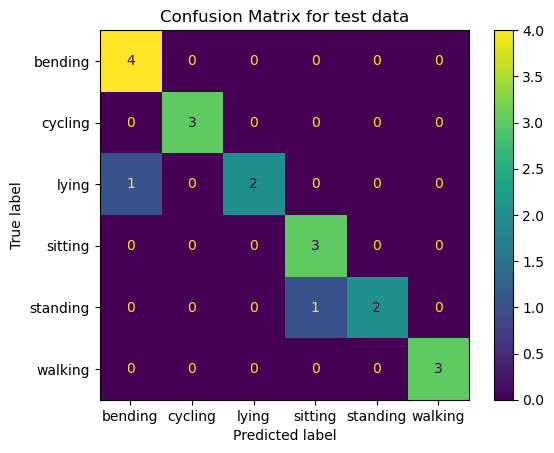

In [32]:
classes = ["bending", "cycling", "lying", "sitting", "standing", "walking"]
plot_confusion_matrix(y_test, y_test_pred, "test", label=classes)

ROC curve using micro-averaged OvR

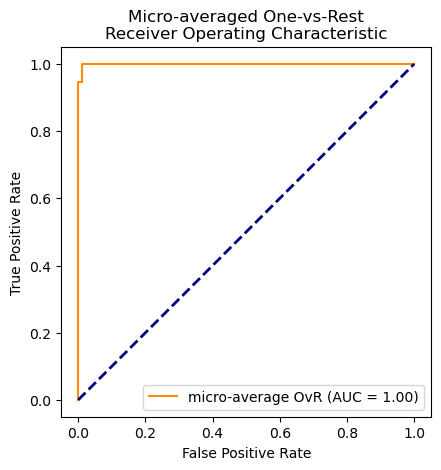

In [31]:
y_score = mclf.predict_proba(X_test)
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",

)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

Macro-averaged One-vs-Rest ROC AUC score:
1.00


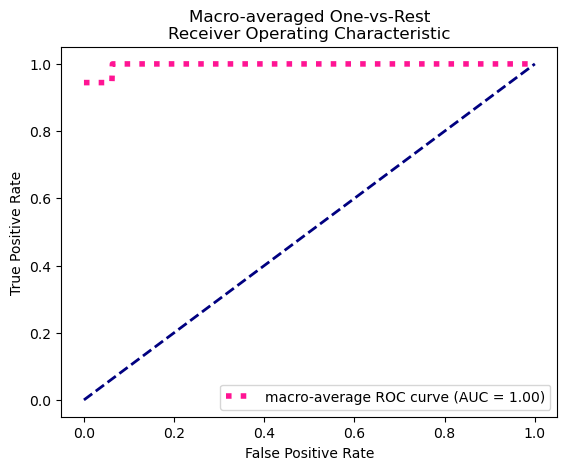

In [32]:
# macro_roc_auc_ovr = roc_auc_score(
#     y_test,
#     y_score,
#     multi_class="ovr",
#     average="macro",
# )
# print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{macro_roc_auc_ovr:.2f}")

fpr, tpr, roc_auc = dict(), dict(), dict()

for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_onehot_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr_grid = np.linspace(0.0, 1.0, 1000)

# Interpolate all ROC curves at these points
mean_tpr = np.zeros_like(fpr_grid)

for i in range(len(classes)):
    mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

# Average it and compute AUC
mean_tpr /= len(classes)

fpr["macro"] = fpr_grid
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
    color="deeppink",
    linestyle=":",
    linewidth=4,
)
         
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Macro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

#### ii. Naive Bayes

In [27]:
def build_nb_clf(prior):
    res = {}
    res["l"] = []
    res["cv_accuracy"] = []
    max_score = 0
    best_model = None

    if prior == "Gaussian":
        clf = GaussianNB()
    elif prior == "Multinomial":
        clf = MultinomialNB()

    for l in range(1,21):
        train_set = build_multi_dataset(activityToTrainData, l)
        X_train = train_set[train_set.columns[1:]]
        y_train = train_set[train_set.columns[0]]
        
        k_fold = KFold(5, shuffle=True, random_state=0)
        score = cross_val_score(clf, X_train, y_train, cv=k_fold, n_jobs=1).max()

        if score > max_score:
            best_model = clf
            max_score = score

        res["l"].append(l)
        res["cv_accuracy"].append(score)

    result = pd.DataFrame(res)
    print(result)
    print("best l:", result.loc[result["cv_accuracy"].idxmax()])
        
    return best_model
   


Using Gaussian prior

In [28]:
gs_clf = build_nb_clf("Gaussian")

     l  cv_accuracy
0    1     0.923077
1    2     0.923077
2    3     0.785714
3    4     0.769231
4    5     0.785714
5    6     0.714286
6    7     0.785714
7    8     0.923077
8    9     0.785714
9   10     0.714286
10  11     0.642857
11  12     0.714286
12  13     0.642857
13  14     0.857143
14  15     0.714286
15  16     0.642857
16  17     0.615385
17  18     0.642857
18  19     0.785714
19  20     0.692308
best l: l              1.000000
cv_accuracy    0.923077
Name: 0, dtype: float64


Test score: 0.8947368421052632


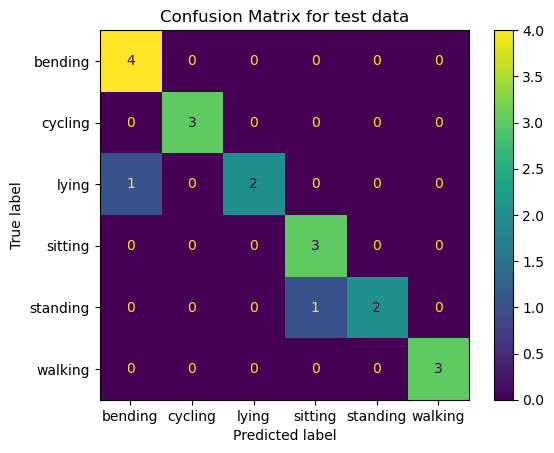

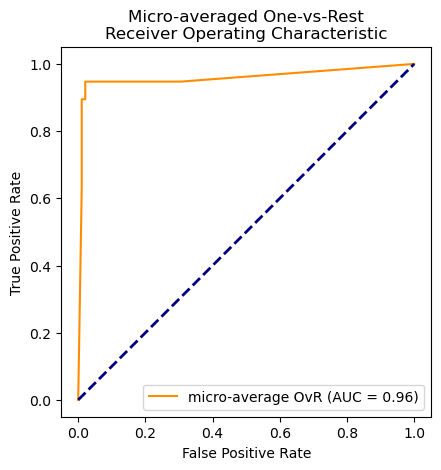

In [38]:
l = 1

train_set = build_multi_dataset(activityToTrainData, l)
X_train = train_set[train_set.columns[1:]]
y_train = train_set[train_set.columns[0]]
gs_clf.fit(X_train, y_train)

test_set = build_multi_dataset(activityToTestData, l)
X_test = test_set.drop('activity_type',axis=1)
y_test = test_set.activity_type

y_test_pred = gs_clf.predict(X_test)
test_score = gs_clf.score(X_test, y_test)
print("Test score:", test_score)

plot_confusion_matrix(y_test, y_test_pred, "test", label=classes)

# plot ROC
y_score = gs_clf.predict_proba(X_test)
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",

)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

In [34]:
mtn_clf = build_nb_clf("Multinomial")

     l  cv_accuracy
0    1     1.000000
1    2     0.923077
2    3     0.923077
3    4     1.000000
4    5     0.928571
5    6     0.928571
6    7     1.000000
7    8     0.928571
8    9     1.000000
9   10     0.923077
10  11     0.923077
11  12     0.923077
12  13     0.928571
13  14     0.923077
14  15     0.923077
15  16     0.923077
16  17     0.923077
17  18     0.923077
18  19     0.923077
19  20     0.923077
best l: l              1.0
cv_accuracy    1.0
Name: 0, dtype: float64


Test score: 0.8947368421052632


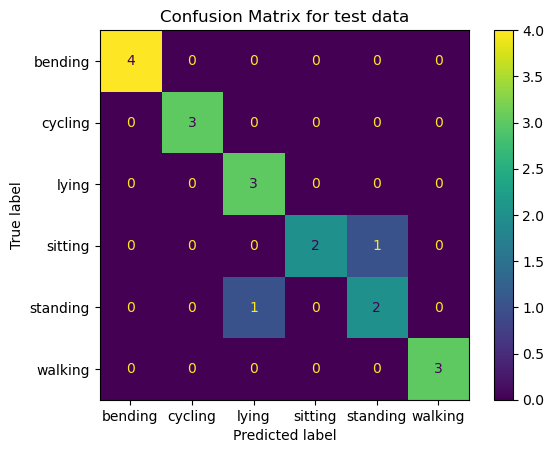

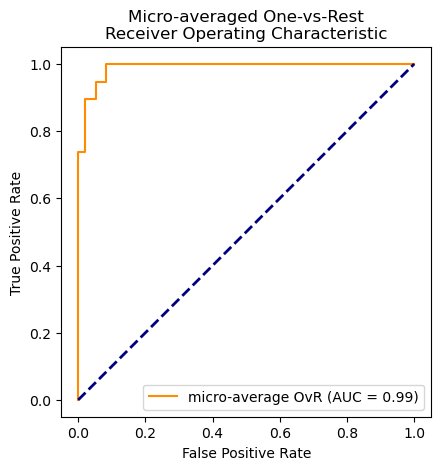

In [40]:
l = 1

train_set = build_multi_dataset(activityToTrainData, l)
X_train = train_set[train_set.columns[1:]]
y_train = train_set[train_set.columns[0]]
mtn_clf.fit(X_train, y_train)

test_set = build_multi_dataset(activityToTestData, l)
X_test = test_set.drop('activity_type',axis=1)
y_test = test_set.activity_type

y_test_pred = mtn_clf.predict(X_test)
test_score = mtn_clf.score(X_test, y_test)
print("Test score:", test_score)

plot_confusion_matrix(y_test, y_test_pred, "test", label=classes)

# plot ROC
y_score = mtn_clf.predict_proba(X_test)
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)

RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",

)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro-averaged One-vs-Rest\nReceiver Operating Characteristic")
plt.legend()
plt.show()

Both Naive Bayes' classifers perform similarly.  
The classfiers might be overfitting because the cross-validation accuracy is higher than test accuracy.

#### iii. Comparison

Logistic regression has the highest test accuracy and works better than both Naive Bayes' classifiers.

## Reference  

logistic regression https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html  
Not converging problem: https://forecastegy.com/posts/how-to-solve-logistic-regression-not-converging-in-scikit-learn/  


Recursive feature elimination with cross-validation to select features: https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html  
example: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py  
https://practicaldatascience.co.uk/machine-learning/how-to-use-recursive-feature-elimination-in-your-models  

logistic regression solver: https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c  
https://stackoverflow.com/questions/38640109/logistic-regression-python-solvers-definitions  

ROC: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html  
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#sklearn.metrics.RocCurveDisplay.from_predictions  
Good ROC when mistakes in confusion matrix: 
https://stats.stackexchange.com/questions/297584/roc-and-accuracy-results-how-can-auc-be-one-if-the-classifier-has-made-mistakes  
multiclass ROC: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html 


statsmodels logit fit: https://www.statsmodels.org/dev/generated/statsmodels.discrete.discrete_model.Logit.fit.html
Not converging: https://saturncloud.io/blog/how-to-deal-with-statsmodels-logistic-regression-convergence-problems/


case-control sampling: https://elitedatascience.com/imbalanced-classes

Select the tuning parameter lamda for lasso: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html  


One hot encoding: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html  
https://www.youtube.com/watch?v=InZ0n2knz1E  

